# Heartrate Variability - 13-Channel EEG/EMG/ECG

- Quality control script for analyzing  cardio-respiratory physiological Synchrony (CRPS)

- Only use with short intervals (1-2 minute recordings)

- For longer recordings, use the command-line hrv.py script 

### User Input

In [1]:
# Files and directories
dir_in = ''
#dir_in = r"C:\Users\haley\Dropbox\Code\Heartrate_Variability\kalume_data"
#dir_in = r"D:\Dropbox\Code\Heartrate_Variability\kalume_data"
file_in = r"Synchrony_EEG_ECG_RESP_K6527_HmzNdufsCrep_10_06_16_TISel.edf" 

# Channel configuration
unfiltered_breath_channel = 8
filtered_breath_channel = 9
ecg_channel = 12
left_eeg_channel = 10
right_eeg_channel = 11
emg_channel = 13

# Thresholds for event detection (* SD)
thresh_ufbreath = 4    # Default = 4 * SD
thresh_breath = 4    # Default = 4 * SD
thresh_ecg = 8   # Default = 8 * SD Avoids contamination of Q-R peak by P or T

# Set up analysis window 
start_mins = 0.0001 # The time (in minutes) that you want to start analyzing the recording
length_mins = "all"  # Length of Recording you wannt to analyze, or 'all'

sample_rate = 1000 # In Hz

### Import dependencies

In [2]:
import pyedflib
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

### Function definitions

In [3]:
def save_csv (df_out, file_out, dir_out):
    """Saves the dataframe to a csv spreadsheet in the specified directory. """
    try:
        os.stat(dir_out)
    except:
        os.makedirs(dir_out)

    # Write data to file
    os.chdir(dir_out)
    df_out.to_csv(file_out, index = True)

def dp2min(datapoints):
    """ Takes either a list or an int and converts to minutes based on sample rate"""
    if type(datapoints) == list:
        minutes = []
        for dp in datapoints:
            mins = dp / (60 * sample_rate)
            minutes.append(mins)
    else:
        minutes = datapoints / (60 * sample_rate)
    return minutes

def dp2s(datapoints):
    """ Takes either a list or an int and converts to milliseconds based on sample rate"""
    if type(datapoints) == list:
        s = []
        for dp in datapoints:
            s = dp / sample_rate
            s.append(int(s))
    else:
        s = datapoints/ sample_rate
    return s

def dp2ms(datapoints):
    """ Takes either a list or an int and converts to milliseconds based on sample rate"""
    if type(datapoints) == list:
        milliseconds = []
        for dp in datapoints:
            ms = dp / sample_rate * 1000
            milliseconds.append(int(ms))
    else:
        milliseconds = datapoints/ sample_rate *1000
    return milliseconds

def min2dp (minutes):
    """ Takes either a list or a float and converts to datapoints (int) based on sample rate"""
    if type(minutes) == list:
        datapoints = []
        for mins in minutes:
            dp = mins * (60 * sample_rate)
            datapoints.append(int(dp))
    else:
        datapoints = int(minutes * 60 * sample_rate)
    return datapoints

def s2dp (seconds):
    """ Takes either a list or a float and converts to datapoints (int) based on sample rate"""
    if type(seconds) == list:
        datapoints = []
        for sec in seconds:
            dp = sec * sample_rate
            datapoints.append(int(dp))
    else:
        datapoints = int(seconds * sample_rate)
    return datapoints

def ms2dp (milliseconds):
    """ Takes either a list or a float and converts to datapoints (int) based on sample rate"""
    if type(milliseconds) == list:
        datapoints = []
        for millisec in milliseconds:
            dp = millisec * sample_rate * 1000
            datapoints.append(int(dp))
    else:
        datapoints = int(milliseconds * sample_rate * 1000)
    return datapoints

def ms2mins (milliseconds):
    """ Takes either a list or a float and converts to datapoints (int) based on sample rate"""
    if type(milliseconds) == list:
        mins = []
        for millisec in milliseconds:
            min = millisec / (60 * 1000)
            mins.append(min)
    else:
        mins = milliseconds / (60 * 1000)
    return mins

def get_edf (dir_in, file_in, file_open):
    """ Opens a Labchart EDF file from the specified file and directory"""
    if file_open == 0:
        file_name = os.path.join(dir_in, file_in)
        f = pyedflib.EdfReader(file_name)
        file_open = 1
    else:
        pass
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i,:] = f.readSignal(i)
    return signal_labels, sigbufs

def get_plot_length (plot_length, sigbufs):
    """ Takes in a plot length in minutes (whole trace or a subsection of a trace)
        and returns it in datapoints"""
    if plot_length == 'all':
        plot_end_time = len(sigbufs[0,:])
    elif plot_length > len(sigbufs[0,:]):
        plot_end_time = len(sigbufs[0,:])
    elif plot_length < 0:
        print ("USER ERROR: Cannot plot a negative plot_length.")
    else:
        plot_end_time = plot_length * (60*sample_rate)
    return int(plot_end_time)

def plot_anything (x, y , x_label, y_label, color, dots):
    fig, ax = plt.subplots(figsize = (10,3), dpi = 100)

    if dots == False:
        ax.plot(x, y, color = color)
    elif dots == True:
        ax.plot(x, y, marker = 'o', markersize = 2, mec = 'black')
    ax.set_xlabel (x_label)
    ax.set_ylabel (y_label)
    y_range = abs(max(y) - min(y))
    ax.set_ylim(min(y) - y_range * 0.1, max(y) + y_range * 0.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

def get_events(x, y, threshold, baseline):
    """ Searches the trace for the specified length (in datapoints) based on the user-specified
        threshold and baseline, with option to plot the results (True/False)"""
    events = []
    if threshold == 0: # first pass will always assume 0 (ground) in template search
        threshold = ((max(y) - min(y))*.1) 
    baseline_x = []
    baseline_y = []
    
    i = 0
    while i < len(x)-1:
        if y[i] < threshold and y[i] > -1*threshold:     
            while y[i] < threshold and i < len(x)-1:
                baseline_x.append (x[i])
                baseline_y.append (y[i])
                i = i + 1
        elif y[i] >= threshold:
            event_x = []
            event_y = []
            peak_x = 0
            peak_y = 0
            while y[i] > threshold and i < len(x)-1:
                event_x.append (x[i])
                event_y.append (y[i])
                i = i + 1
            event = {'signal': signal, 'x': event_x, 'y': event_y}
            events.append (event)
        else: 
            i = i + 1
    baseline_mean = np.mean(baseline_y)
    baseline_std = np.std(baseline_y)
    return [events, baseline_mean, baseline_std]


def get_event_stats (events, baseline):
    df = pd.DataFrame({'peaks_y': [], 'peaks_x' : [], 'peaks_amp': [], 'widths' : [], 'half_width_x':[], 'half_width_y':[]})
    for event in events:
        peak_y = max (event['y'])
        peak_amp = max (event['y']) - baseline
        width = max(event['x']) - min(event['x'])
        half_peak = peak_y/2
        half_x = 0
        half_y = 0
        i = 0
        while i < len(event['x'])-1:
            if event['y'][i] < event['y'][i + 1]:
                peak_x = event['x'][i]
                i = i + 1
            else:
                i = len(event['x'])            
        row = {'peaks_y': peak_y, 'peaks_x' : peak_x, 'peaks_amp': peak_amp, 'widths' : width, 
               'half_width_x': half_x, 'half_width_y' : half_y}
        #print(row)
        df = df.append(row, ignore_index = True)
    return df

def plot_events (ax, events,event_xmax, event_ymax, y_label): # For each sognal, for each event, plot the event
    ax.spines ['top'].set_visible (False)
    ax.spines ['right'].set_visible (False)
    x = list(range(event_xmax))
    y = [0] * event_xmax
    n = [0] * event_xmax
    y_mean = [np.nan] * event_xmax
    for event in events:
        i = 0
        for event_y in event['y']:
            if i < len(x):
                y[i] = y[i] + event_y
                n[i] = n[i] + 1
                i = i + 1
            else:
                i = 0
                y[i] = y[i] + event_y
                n[i] = n[i] + 1
                i = i + 1
        event_x = list(range(len(event['y'])))
        ax.plot (dp2ms(event_x), event['y'], color = 'gray', lw = 1)
    i = 0
    while i < len(x): 
        if np.isnan(y[i]) == False:
            y_mean[i] = y[i]/n[i]
        i = i + 1
         
    ax.plot (dp2ms(x), y_mean, color = 'black', lw = 4)
    ax.set_xlabel ("Time (ms)")
    ax.set_ylabel ("Voltage (V)")
    ax.set_title(y_label)
    plt.tight_layout()
    return ax

def get_epochs (desc_list):
    df_breath = desc_list[1]
    df_heart = desc_list[2]
    epochs = []
    i = 0 # Breath counter
    j = 0 # Heartbeat counter
    while i < len(df_breath.peaks_x)-1:
        heartbeats_x = []
        heartbeats_y = []
        heartbeats_width = []
        latencies = []
        
        if df_heart.peaks_x[j] < df_breath.peaks_x[0]:
            j = j + 1
        else:
            while df_heart.peaks_x[j] >= df_breath.peaks_x[i] and df_heart.peaks_x[j] < df_breath.peaks_x[i+1]:
                #print(heart_events[j]['peak_x'], breath_events[i]['peak_x'], breath_events[i+1]['peak_x'])
                heartbeats_x.append(df_heart.peaks_x[j])
                heartbeats_y.append(df_heart.peaks_y[j])                
                heartbeats_width.append(df_heart.widths[j])
                latencies.append(df_heart.peaks_x[j] - df_breath.peaks_x[i])
                j = j + 1
            epoch_length = df_breath.peaks_x[i+1] - df_breath.peaks_x[i] # breath duration
            epoch = {'breath_x': df_breath.peaks_x[i], 'heartbeats_x': heartbeats_x, 'heartbeats_y': heartbeats_y, 
                     'breaths_width': df_breath.widths[i], 'heartbeats_width': heartbeats_width, 
                     'epoch_length':epoch_length, 'latencies':latencies}
            epochs.append(epoch)
            i = i + 1
    return epochs

### Default Values

In [4]:
# Channel refers to Labchart numbering, which starts at 1
channel_list = {'Unfiltered_Breath' : unfiltered_breath_channel, 
                'Filtered_Breath' : filtered_breath_channel, 
                'ECG': ecg_channel,
                'Left_EEG' : left_eeg_channel, 
                'Right_EEG' : right_eeg_channel, 
                'EMG': emg_channel}
amp_channels =  {'Unfiltered_Breath' : unfiltered_breath_channel, 
                'Filtered_Breath' : filtered_breath_channel, 
                'ECG': ecg_channel}
freq_channels = {'Left_EEG' : left_eeg_channel, 
                'Right_EEG' : right_eeg_channel, 
                'EMG': emg_channel} 


# Signal refers to Python numbering, which starts at 0
signal_list = channel_list.copy()
label_list = []
for keys, values in signal_list.items():
    signal_list[keys] = values - 1
    label_list.append(keys)
    
amp_signals = amp_channels.copy()
amp_labels = []
for keys, values in amp_signals.items():
    amp_signals[keys] = values - 1
    amp_labels.append(keys)
    
freq_signals = freq_channels.copy()
freq_labels = []
for keys, values in freq_signals.items():
    freq_signals[keys] = values - 1
    freq_labels.append(keys)
                    
file_open = 0   # 0 = EDF file hasn't been opened, 1 = it has been opened

# Read in the raw traces for each channel
signal_labels, sigbufs = get_edf (dir_in, file_in, file_open) # reads in all channels

# Traces per channel
x_dp = list(range (0,len(sigbufs[0]))) # x values for all channels in datapoints
x_mins = [dp2min(x) for x in x_dp] # x values for all channels in minutes
x_s = [dp2s(x) for x in x_dp] # x values for all channels in seconds
y_breath_unfiltered = sigbufs[signal_list['Unfiltered_Breath'],:]
y_breath = sigbufs[signal_list['Filtered_Breath'],:]
y_ecg = sigbufs[signal_list['ECG'],:]
y_eeg_l = sigbufs[signal_list['Left_EEG'],:]
y_eeg_r = sigbufs[signal_list['Right_EEG'],:]
y_emg = sigbufs[signal_list['EMG'],:]
y_amp = [y_breath_unfiltered, y_breath, y_ecg]
y_freq = [y_eeg_l, y_eeg_r, y_emg]
y_list = y_amp + y_freq

# Window variables
start_dp = min2dp(start_mins)
start_s = dp2s(start_dp)
start_ms = dp2ms(start_dp)
end_mins = start_mins + get_plot_length (length_mins, sigbufs) # Gets plot length in datapoints
end_dp = min2dp (end_mins)
end_s = dp2s (end_dp)
end_ms = dp2ms (end_dp)

# Event detection
thresholds = {'Unfiltered_Breath': thresh_ufbreath,  
              'Filtered_Breath': thresh_breath,
              'ECG': thresh_ecg}


### Plot all Signals

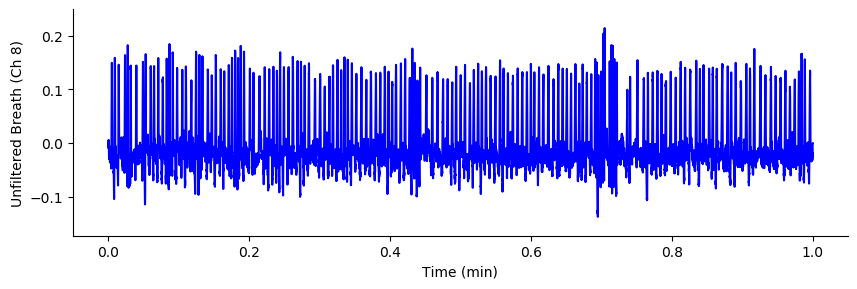

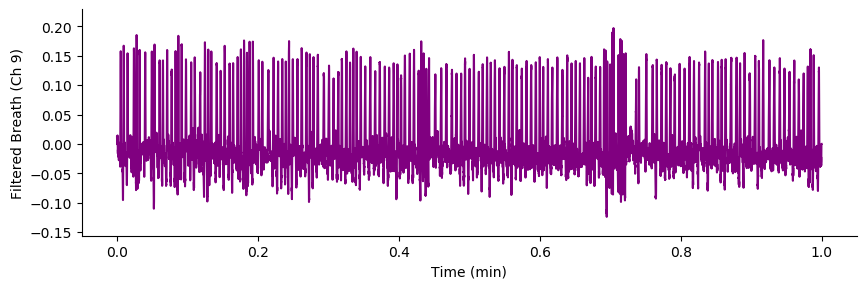

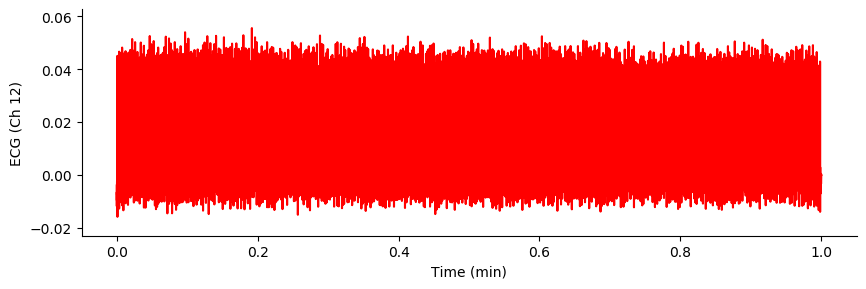

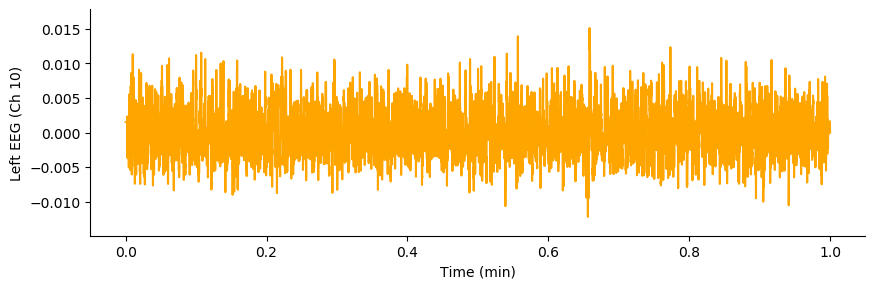

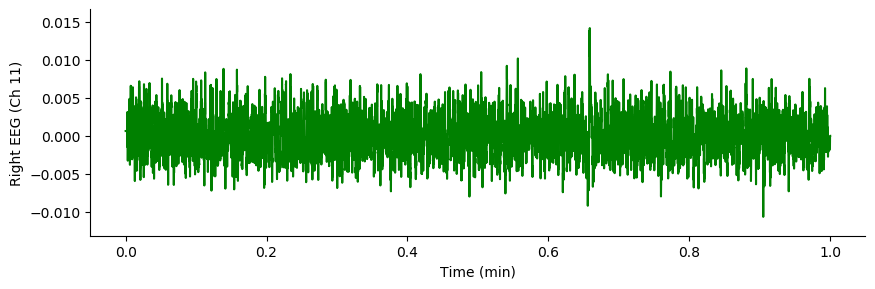

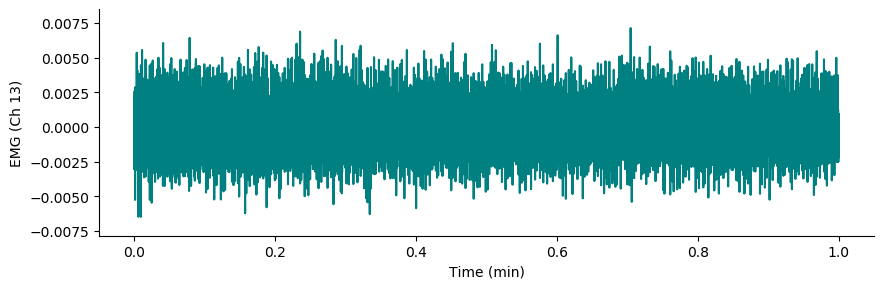

In [5]:
i = 0
colors = ['blue', 'purple', 'red', 'orange', 'green', 'teal']
for y in y_list:
    plot_anything(x = x_mins, 
                  y = y,
                  x_label = 'Time (min)',
                  y_label = label_list[i].replace('_', ' ') + ' (Ch ' + str(channel_list[label_list[i]]) + ')',
                  color = colors[i],
                  dots = False)
    i = i + 1

### Define Template

,peaks_y,peaks_x,peaks_amp,widths,half_width_x,half_width_y
0,0.149375,316.0,0.149375,51.0,0.0,0.0
1,0.158750,570.0,0.158750,49.0,0.0,0.0
2,0.145937,898.0,0.145937,51.0,0.0,0.0
3,0.163750,1439.0,0.163750,58.0,0.0,0.0
4,0.182188,1666.0,0.182188,54.0,0.0,0.0


,peaks_y,peaks_x,peaks_amp,widths,half_width_x,half_width_y
0,0.157768,316.0,0.157768,55.0,0.0,0.0
1,0.167146,570.0,0.167146,52.0,0.0,0.0
2,0.154202,898.0,0.154202,58.0,0.0,0.0
3,0.162656,1439.0,0.162656,59.0,0.0,0.0
4,0.185318,1668.0,0.185318,56.0,0.0,0.0


,peaks_y,peaks_x,peaks_amp,widths,half_width_x,half_width_y
0,0.045080,54.0,0.045080,4.0,0.0,0.0
1,0.046658,200.0,0.046658,4.0,0.0,0.0
2,0.046220,343.0,0.046220,4.0,0.0,0.0
3,0.007535,343.0,0.007535,0.0,0.0,0.0
4,0.048212,456.0,0.048212,4.0,0.0,0.0


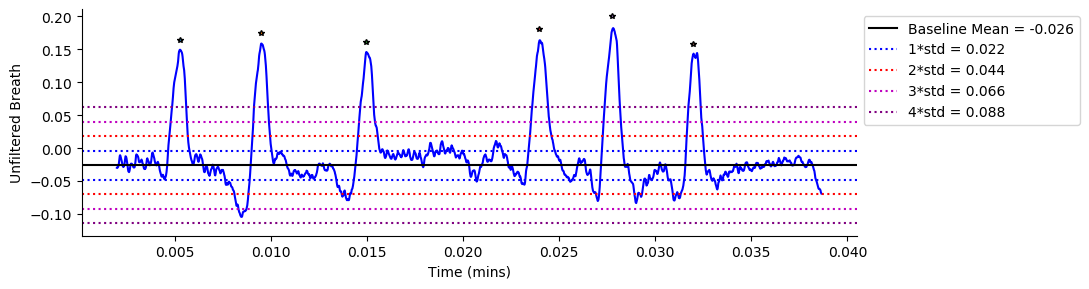

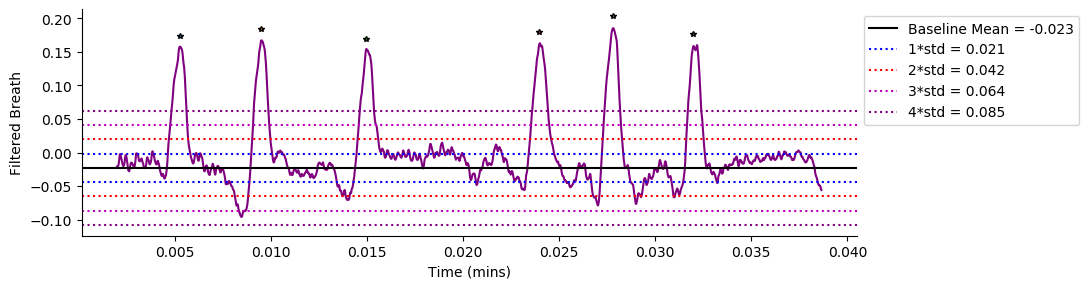

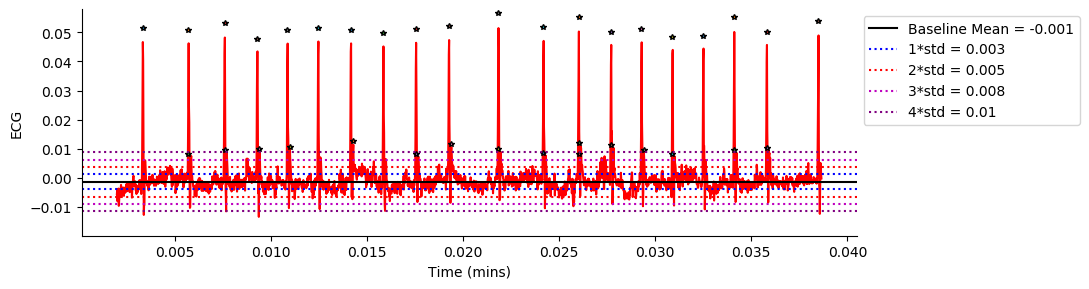

In [6]:
baseline = []
std = []
events_list = []
i = 0
for signal in amp_signals:
    threshold = 0
    result = get_events(x_dp, y_amp[i], threshold, 0) 
    """ result = events, baseline_mean, baseline_std """
    events_list.append(result[0])
    baseline.append(result[1])
    std.append(result[2])
    fig, ax = plot_anything(x = x_mins [120:2320], 
                  y = y_amp[i][120:2320] , 
                  x_label = "Time (mins)",
                  y_label = amp_labels[i].replace('_', ' '), 
                  color = colors[i], 
                  dots = False)
    # Get peaks for each event
    df_events = get_event_stats (result[0], 0)
    display(HTML(df_events.head().to_html()))
    for index, row in df_events.iterrows():
        if dp2min(row.peaks_x) >= x_mins[120] and dp2min(row.peaks_x) <= x_mins[2320]: 
            ax.plot(dp2min(row.peaks_x), row.peaks_y + row.peaks_y*0.1, ls = 'none', marker = '*', mec = 'black', ms = 4)
    # Add mean +/- SD to plots
    ax.axhline(result[1], color = "k", ls = "solid", label = "Baseline Mean = " + str(round(result[1],3)))
    ax.axhline(result[1] + result[2], color='b', linestyle=':', label = "1*std = " + str(round(result[2],3)))
    ax.axhline(result[1] + 2*result[2], color='r', linestyle=':', label = "2*std = " + str(round(result[2]*2,3)))
    ax.axhline(result[1] + 3*result[2], color='m', linestyle=':', label = "3*std = " + str(round(result[2]*3,3)))
    ax.axhline(result[1] + 4*result[2], color='purple', linestyle=':', label = "4*std = " + str(round(result[2]*4,3)))
    ax.axhline(result[1] - result[2], color='b', linestyle=':')
    ax.axhline(result[1] - 2*result[2], color='r', linestyle=':')
    ax.axhline(result[1] - 3*result[2], color='m', linestyle=':')
    ax.axhline(result[1] - 4*result[2], color='purple', linestyle=':')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend (handles, labels, bbox_to_anchor = (1,1))
    
    i = i + 1



### Refine Event Search

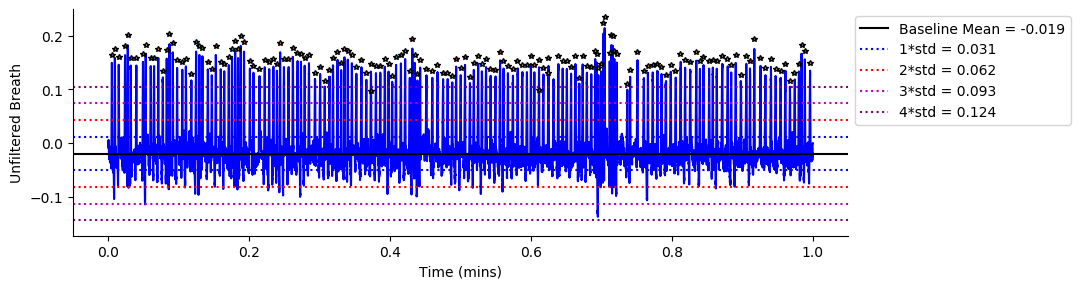

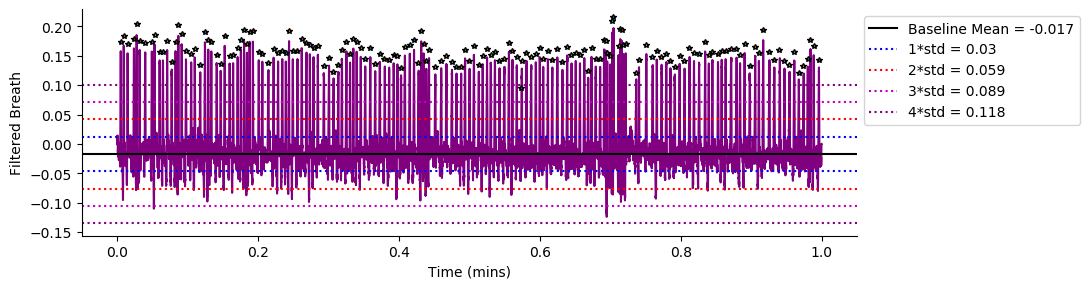

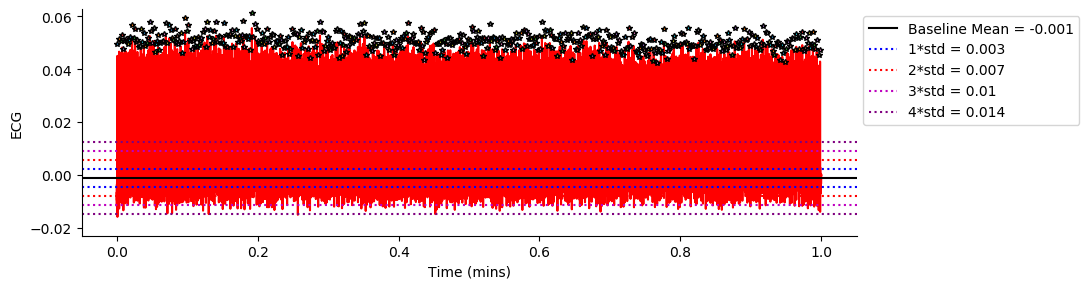

In [7]:
baselines = []
stds = []
events_list = []
desc_list = []
i = 0
for signal in amp_signals:
    result = get_events(x_dp, 
                        y_amp[i],
                        thresholds[amp_labels[i]] * std[i], 
                        baseline[i]) 
    """ result = events, baseline_mean, baseline_std """
    events_list.append(result[0])
    baselines.append(result[1])
    stds.append(result[2])
    fig, ax = plot_anything(x = x_mins [:], 
                  y = y_amp[i][:] , 
                  x_label = "Time (mins)",
                  y_label = amp_labels[i].replace('_',' '), 
                  color = colors[i], 
                  dots = False)
    # Get peaks for each event
    df_events = get_event_stats (result[0], 0)
    desc_list.append(df_events)
    for index, row in df_events.iterrows():
        if dp2min(row.peaks_x) >= min(x_mins[:]) and dp2min(row.peaks_x) <= max(x_mins[:]): 
            ax.plot(dp2min(row.peaks_x), row.peaks_y + row.peaks_y*0.1, ls = 'none', marker = '*', mec = 'black', ms = 4)
    # Add mean +/- SD to plots
    ax.axhline(result[1], color = "k", ls = "-", label = "Baseline Mean = " + str(round(result[1],3)))
    ax.axhline(result[1] + result[2], color='b', linestyle=':', label = "1*std = " + str(round(result[2],3)))
    ax.axhline(result[1] + 2*result[2], color='r', linestyle=':', label = "2*std = " + str(round(result[2]*2,3)))
    ax.axhline(result[1] + 3*result[2], color='m', linestyle=':', label = "3*std = " + str(round(result[2]*3,3)))
    ax.axhline(result[1] + 4*result[2], color='purple', linestyle=':', label = "4*std = " + str(round(result[2]*4,3)))
    ax.axhline(result[1] - result[2], color='b', linestyle=':')
    ax.axhline(result[1] - 2*result[2], color='r', linestyle=':')
    ax.axhline(result[1] - 3*result[2], color='m', linestyle=':')
    ax.axhline(result[1] - 4*result[2], color='purple', linestyle=':')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend (handles, labels, bbox_to_anchor = (1,1))
    df_events.to_csv(file_in.replace('.edf', '_' + str(amp_labels[i]) + '_events.csv'))
    i = i + 1


    

### Preview event statistics

In [8]:
for df in desc_list:
    display(HTML(df.head().to_html()))

,peaks_y,peaks_x,peaks_amp,widths,half_width_x,half_width_y
0,0.149375,316.0,0.149375,36.0,0.0,0.0
1,0.158750,570.0,0.158750,36.0,0.0,0.0
2,0.145937,898.0,0.145937,32.0,0.0,0.0
3,0.163750,1439.0,0.163750,41.0,0.0,0.0
4,0.182188,1666.0,0.182188,41.0,0.0,0.0


,peaks_y,peaks_x,peaks_amp,widths,half_width_x,half_width_y
0,0.157768,316.0,0.157768,40.0,0.0,0.0
1,0.167146,570.0,0.167146,40.0,0.0,0.0
2,0.154202,898.0,0.154202,35.0,0.0,0.0
3,0.162656,1439.0,0.162656,41.0,0.0,0.0
4,0.185318,1668.0,0.185318,43.0,0.0,0.0


,peaks_y,peaks_x,peaks_amp,widths,half_width_x,half_width_y
0,0.045080,54.0,0.045080,2.0,0.0,0.0
1,0.046658,200.0,0.046658,2.0,0.0,0.0
2,0.046220,343.0,0.046220,2.0,0.0,0.0
3,0.048212,456.0,0.048212,2.0,0.0,0.0
4,0.043438,558.0,0.043438,2.0,0.0,0.0


### Plot events

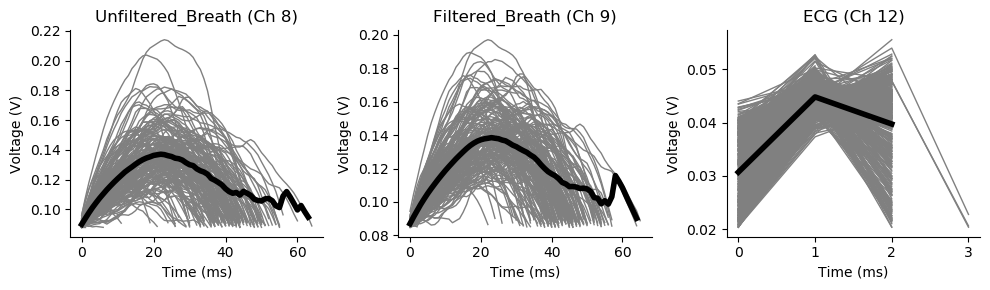

In [9]:
fig, ax = plt.subplots(1,3, figsize = (10,3), dpi = 100)
for i in range(len(events_list)):
    y_label = amp_labels[i] + ' (Ch ' + str(amp_channels[amp_labels[i]]) + ')'
    ax[i] = plot_events(ax[i], events_list[i], int(max(desc_list[i].widths)), max(desc_list[i].peaks_y), y_label)


### Get Cardiorespiratory Epochs

In [15]:
"""'Each epoch contains: breath_x, heartbeats_x, heartbeats_y, breaths_width, heartbeats_width, epoch_length, latencies""" 
epochs = get_epochs (desc_list)

row = {}
df = pd.DataFrame(row)
i = 0
for epoch in epochs:
    j = 0
    if i < len(epochs):
        for beat in epoch['heartbeats_x']:
            row['R_time_mins'] = ms2mins(epoch['breath_x']) 
            row['R_duration_ms'] = epoch['epoch_length']
            row['C_time_mins'] = ms2mins(beat)
            row['C_R_latency_ms'] = beat - epoch['breath_x']
            row['C_R_fraction'] = row['C_R_latency_ms'] / epoch['epoch_length'] 
            row['C_index'] = j+1
            row['C_C_latency_ms'] = beat - epoch['heartbeats_x'][j-1]
            if row['C_C_latency_ms'] < 0:
                row['C_C_latency_ms'] = np.nan
            df = df.append(row, ignore_index = True)
            j = j + 1
        i = i + 1
df = df[['R_time_mins', 'R_duration_ms', 'C_time_mins', 'C_R_latency_ms', 'C_R_fraction', 'C_index', 'C_C_latency_ms']]
display(HTML(df.head().to_html()))
#save_csv(df, file_in.replace('.edf', '.csv'), dir_in)
save_csv(df, file_in.replace('.edf', '.csv'), str(os.getcwd))


,R_time_mins,R_duration_ms,C_time_mins,C_R_latency_ms,C_R_fraction,C_index,C_C_latency_ms
0,0.005267,254.0,0.005717,27.0,0.106299,1.0,NaN
1,0.005267,254.0,0.007600,140.0,0.551181,2.0,113.0
2,0.005267,254.0,0.009300,242.0,0.952756,3.0,102.0
3,0.009500,328.0,0.010867,82.0,0.250000,1.0,NaN
4,0.009500,328.0,0.012467,178.0,0.542683,2.0,96.0


### Cardiorespiratory phase synchronization

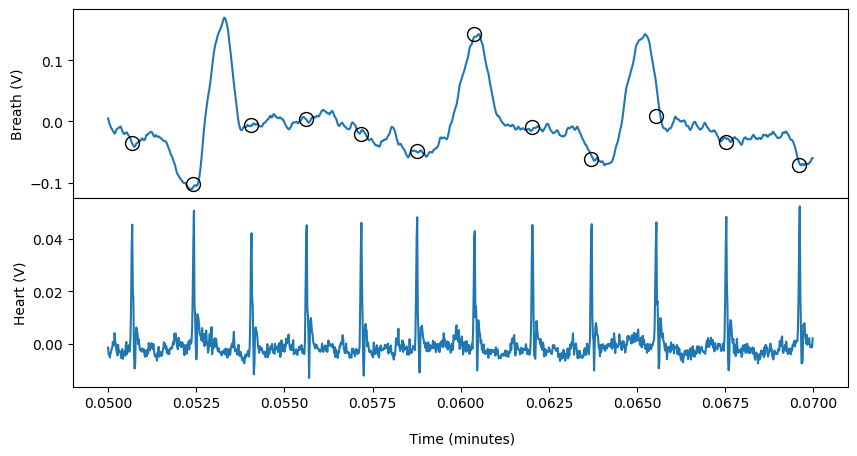

In [16]:
# User Input
start_mins = 0.05
end_mins = 0.07

start_dp = min2dp (start_mins)
end_dp = min2dp(end_mins)
plot_duration = end_mins/start_mins

fig, ax = plt.subplots(2, figsize = (10,5), dpi = 100)

ax[0].plot(x_mins[start_dp:end_dp],y_breath[start_dp:end_dp])
ax[0].set_xticks([])
ax[1].plot(x_mins[start_dp:end_dp], y_ecg[start_dp:end_dp])
ax[1].set_xlabel ("\n Time (minutes)")
ax[0].set_ylabel ('Breath (V)')
ax[1].set_ylabel ('Heart (V)')

# Find first breath from 
i = 0
while i < len(df.R_time_mins):
    if df.C_time_mins[i] >= start_mins and df.R_time_mins[i] < end_mins:
        x = df.C_time_mins[i]
        y = y_breath[round(min2dp(x+0.0001*plot_duration))]
        #ax[0].annotate(r'$_o$', xy = (x, y), size = 18, color = 'red')
        ax[0].plot(x, y, ls = 'none', marker = 'o', mec = 'black', color = 'none', markersize = 10)
        
    i = i + 1


fig.subplots_adjust(hspace=0)


### Plot Breath Durations

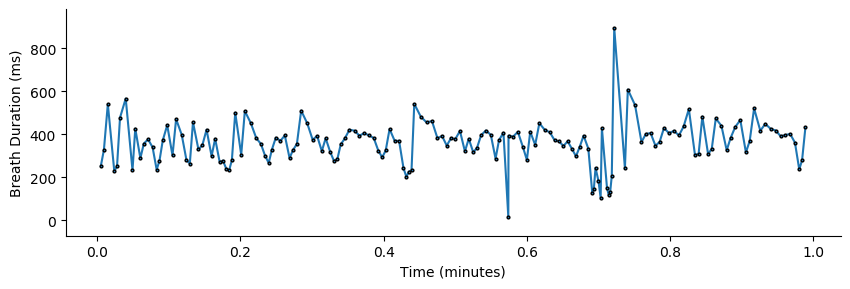

In [17]:
breath_durations = [epoch['epoch_length'] for epoch in epochs]
breath_peak_times = [epoch['breath_x'] for epoch in epochs]
# Subset x, y , x_label, y_label, color, dots
#fig, ax = plot_anything (dp2min(breath_peak_times[0:10]), breath_durations[0:10], 'Time (minutes)', 'Breath Duration (ms)', 'blue', True) 
# Full recording
fig, ax = plot_anything (dp2min(breath_peak_times), breath_durations, 'Time (minutes)', 'Breath Duration (ms)', ' blue', True) 


### Plot heartbeat latency as fraction of breath duration (Subset)

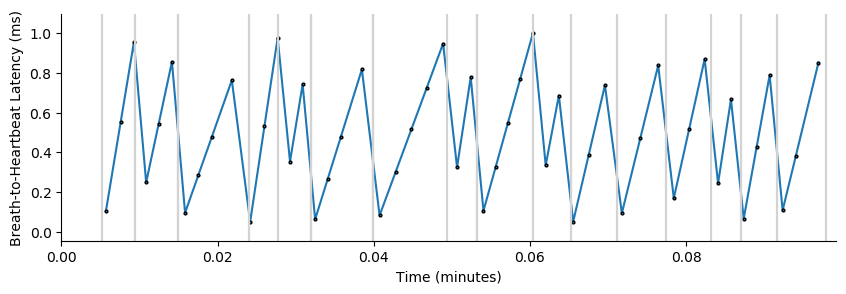

In [18]:
fig, ax = plot_anything (df.C_time_mins[0:50], df.C_R_fraction[0:50], 'Time (minutes)', 
                         'Breath-to-Heartbeat Latency (ms)', 'blue', True) 

for breath in df.R_time_mins:
    ax.axvline(breath, color = "lightgray")
ax=ax.set_xlim(0, df.C_time_mins[50])

### Plot heartbeat latency as fraction of breath duration (Full)

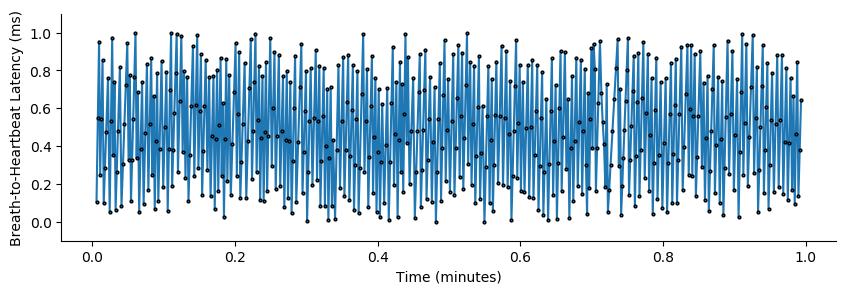

In [19]:
fig, ax = plot_anything (df.C_time_mins, df.C_R_fraction, 'Time (minutes)', 
                         'Breath-to-Heartbeat Latency (ms)', 'blue', True) 


### Poincare plot

(0, 200)

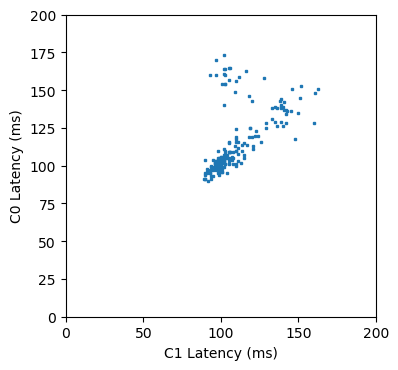

In [20]:
i = 0
x = []
y = []
while i < len(df.C_C_latency_ms)-1:
    if df.C_C_latency_ms[i] > 0 and df.C_C_latency_ms[i+1] > 0:
        x.append(df.C_C_latency_ms[i])
        y.append(df.C_C_latency_ms[i+1])
    i = i + 1
fig, ax = plt.subplots (figsize = (4,4), dpi = 100)
ax.plot (x, y, ls = 'none', marker = 's', markersize = 2)
ax.set_xlabel ('C1 Latency (ms)')
ax.set_ylabel ('C0 Latency (ms)')
ax.set_xlim(0,200)
ax.set_ylim (0,200)

### Power Analysis of EMG and EEG

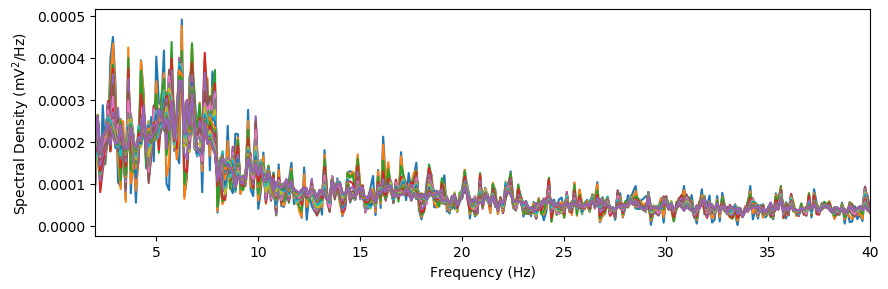

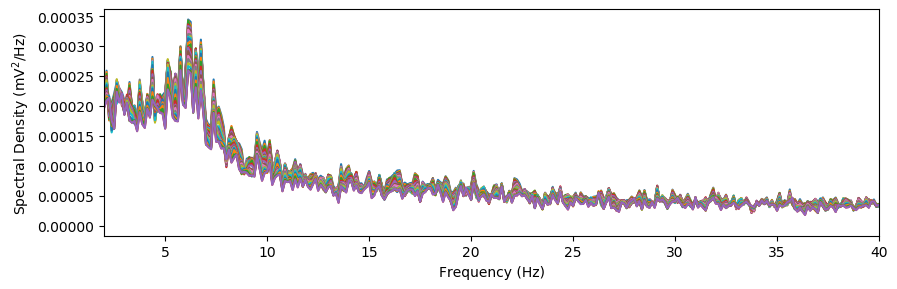

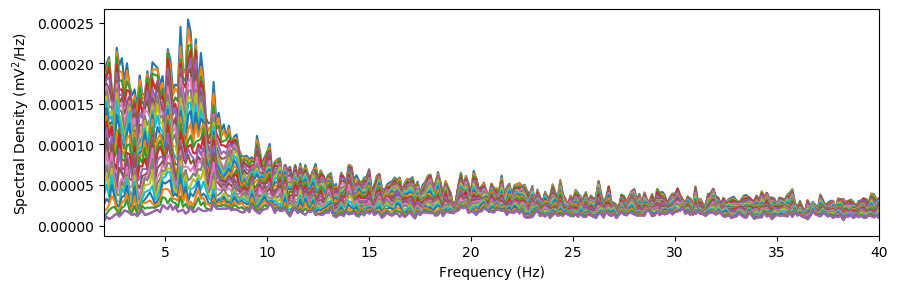

In [131]:
def part_fft(x,y):
    sampling_interval = 1000/sample_rate

    # Frequency domain representation
    xform = np.fft.fft(y)/len(y) # Normalize amplitude
    xform = xform[range(int(len(y)/2))] # Exclude sampling frequency
    timepoints = len(y)
    values      = np.arange(int(timepoints/2))
    time_period  = timepoints/sample_rate
    frequencies = values/time_period

    #fig, ax = plt.subplots(figsize = (10,3), dpi= 100)
    #ax.plot(x,y)
    #ax.plot(frequencies[2:], abs(xform)[2:])
    #ax.set_xlim(2,10)
    #ax.set_ylim (0,1)
    return frequencies[2:], abs(xform)[2:]


df_fft = pd.DataFrame()

for signal in range (0,len(freq_signals)):
    i = 0
    step = 2 * sample_rate
    win_start = start_dp - step
    win_end = 0
    fig, ax = plt.subplots(figsize = (10,3), dpi= 100)
    while i <= (win_end)/step:
        win_start = win_start + step
        win_end = win_start + step * 4
        frequencies, xform = part_fft(x_dp[win_start:win_end], y_freq[signal][win_start:win_end])
        if i == 0:
            df_fft['frequencies'] = frequencies
            df_fft = df_fft.set_index('frequencies')
            i = i + 1
        else:
            if len(frequencies) == len(df_fft.index):
                df_fft[str(i)] = xform
                df_fft['avg'] = df_fft.mean(axis = 1) 
            else:
                i = win_end/step
            ax.plot(df_fft.index.values, df_fft.avg)
            ax.set_xlim(2,40)
            ax.set_xlabel ('Frequency (Hz)')
            ax.set_ylabel ('Spectral Density (mV' + r'$^2$' + '/Hz)')
            df_fft.to_csv('power_' + freq_labels[signal] + '_' + str(round(win_start/(sample_rate * 60),2)) + '_to_' + str(round(win_end/(sample_rate * 60),2)) + '.csv') 
        i = i + 1  
    
    
